In [5]:
import xarray as xr, glob, re, os, cartopy, matplotlib.pyplot as plt, pandas as pd, regionmask, geopandas as gpd, datetime, numpy as np
from IPython.display import clear_output
from functools import reduce

mapproj = cartopy.crs.PlateCarree()
xn,xx,yn,yx = [-86,-55,10,27]


from dateutil.relativedelta import relativedelta
def decode_times(ts):
    
    # Method to manually decode times
    
    inc = re.sub(" .+", "", ts.time.units)
    startdate = pd.Timestamp(re.sub(".+since ", "", ts.time.units)+' 00:00:00.000000').to_pydatetime()
    
    if inc == "years":
        new_times = [np.datetime64(startdate + relativedelta(years = i)) for i in ts.time.values]
    elif inc == "months":
        new_times = [np.datetime64(startdate + relativedelta(months = i)) for i in ts.time.values]
    elif inc == "days":
        new_times = [np.datetime64(startdate + relativedelta(days = i)) for i in ts.time.values]
    elif inc == "hours":
        new_times = [np.datetime64(startdate + relativedelta(hours = i)) for i in ts.time.values]
    else:
        print("TBD: " +inc)
        return
        
    ts = ts.assign_coords(time = new_times)
    
    return ts


def wrap_lon(ds):
    
    # method to wrap longitude from (0,360) to (-180,180)
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds

# Compile MSWX data

ssh in and run from shell terminal (NOT in Jupyter)
```
dpath=/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswx/P
outpath=/rds/general/user/cb2714/home/99_ephemera/mswx-P

for y in `ls $dpath`; do cdo -O mergetime $dpath/$y/*.nc $outpath/tmp.nc; cdo -O sellonlatbox,-86,-55,10,27 $outpath/tmp.nc $outpath/$y.nc; rm $outpath/tmp.nc; done
cdo -O mergetime $outpath/*.nc /rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/hurricane-melissa/precip/pr_mswx.nc
```

In [9]:
mswx = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/hurricane-melissa/precip/pr_mswx.nc").precipitation

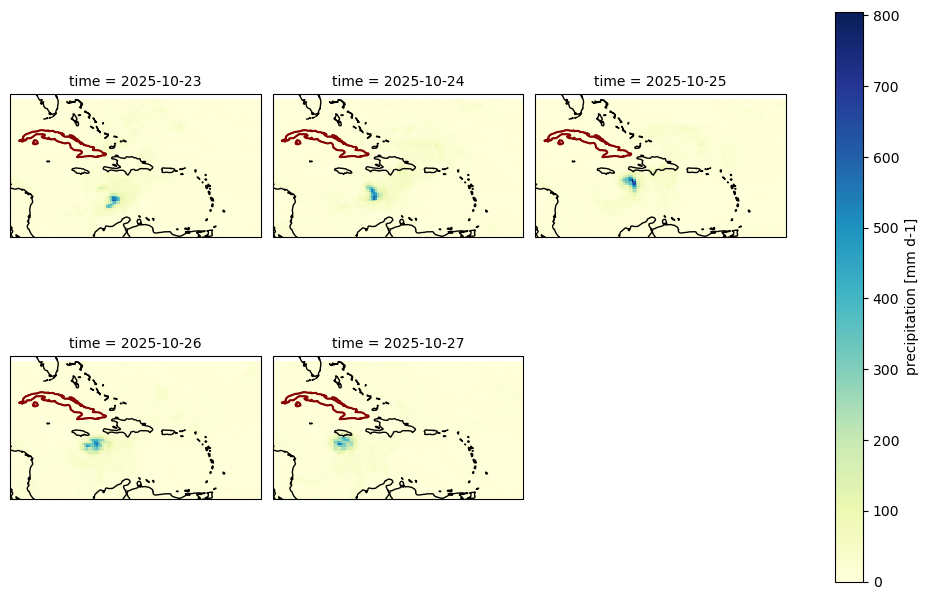

In [47]:
fig = mswx.isel(time = slice(-5,None)).plot(col = "time", col_wrap = 3, cmap = "YlGnBu",
                                                          subplot_kws = {"projection" : cartopy.crs.PlateCarree(),
                                                                         "extent" : (-86,-55,10,27)})
for ax in fig.axs.flatten():
    ax.coastlines()
    z.boundary.plot(ax = ax, color = "darkred")

# IBtracs

In [17]:
! wget https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/ibtracs.NA.list.v04r01.csv -O data/ibtracs_NA.csv

--2025-10-30 12:25:08--  https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/ibtracs.NA.list.v04r01.csv
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 2610:20:8040:2::168, 2610:20:8040:2::167, 2610:20:8040:2::171, ...
connected. to www.ncei.noaa.gov (www.ncei.noaa.gov)|2610:20:8040:2::168|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 57331922 (55M) [text/csv]
Saving to: ‘data/ibtracs_NA.csv’

data/ibtracs_NA.csv 100%[===================>]  54.68M  20.6MB/s    in 2.6s    

2025-10-30 12:25:12 (20.6 MB/s) - ‘data/ibtracs_NA.csv’ saved [57331922/57331922]



## Confirm track region

In [18]:
df = pd.read_csv("data/ibtracs_NA.csv").iloc[1:]
melissa = df.loc[(df.NAME == "MELISSA") & (df.SEASON == 2025)]

/var/tmp/pbs.1094658.pbs-7/ipykernel_3509558/711173608.py:1: DtypeWarning: Columns (1,2,3,8,9,14,19,20,23,24,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/ibtracs_NA.csv").iloc[1:]


In [21]:
melissa.to_csv("ibtracs-melissa.csv", index = None)

In [90]:
mswx = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/hurricane-melissa/precip/pr_mswx.nc").precipitation

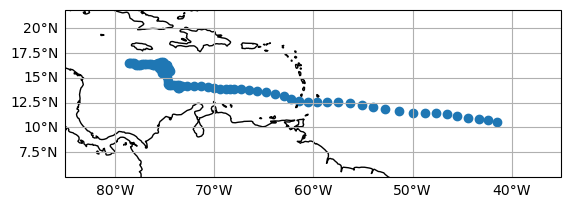

In [74]:
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj, "extent" : (-85,-35,5,20)})

ax.scatter(melissa.LON, melissa.LAT)
ax.coastlines()
ax.gridlines(draw_labels = ["bottom", "left"])

## Identify TC days around Jamaica

In [79]:
jm = regionmask.defined_regions.natural_earth_v5_1_2.countries_50.to_geodataframe().set_index("names").loc[["Jamaica"]] 

In [81]:
jm.geometry.bounds

,minx,miny,maxx,maxy
names,,,,
Jamaica,-78.339502,17.714941,-76.210791,18.522217


In [103]:
bxn,bxx,byn,byx = [-80.5,-74,15.5,20.5]

<GeoAxes: title={'center': 'time = 2025-10-27'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

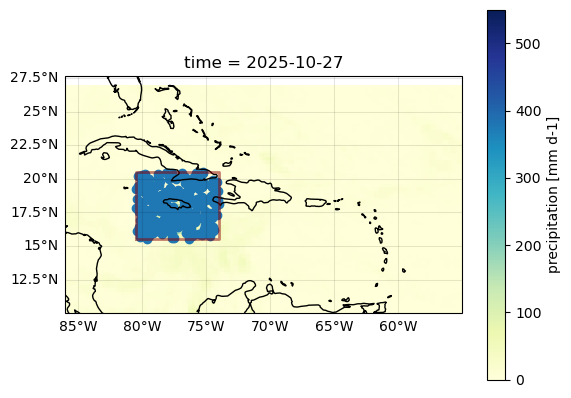

In [196]:
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})
mswx.isel(time = -1).plot(ax = ax, cmap = "YlGnBu")
ax.coastlines()
ax.gridlines(draw_labels = ["bottom", "left"], color = "k", alpha = 0.1)

ax.plot([bxn,bxn,bxx,bxx,bxn], [byn,byx,byx,byn,byn], color = "darkred", lw = 2, alpha = 0.5)

In [202]:
df["DATE"] = [dt[:10] for dt in df.ISO_TIME]

px_daily = df[["LON", "LAT", "NAME", "DATE"]].groupby(["NAME", "DATE"]).mean().reset_index()
px_daily.to_csv("ibtracs-dailymean.csv")

px_daily = gpd.GeoDataFrame(px_daily, geometry = gpd.points_from_xy(px_daily.LON, px_daily.LAT), crs = mapproj)

px_daily["datetime"] = [datetime.datetime(int(d[:4]), int(d[5:7]), int(d[8:10])) for d in px_daily.DATE]
px_daily = px_daily.set_index("datetime")

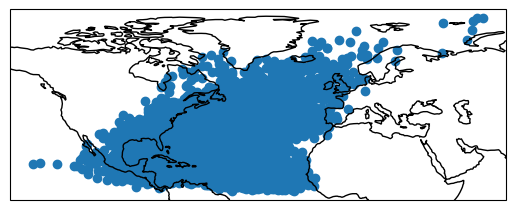

In [205]:
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj})
ax.scatter(px_daily.LON, px_daily.LAT)
ax.coastlines()

In [236]:
px_j = px_daily.clip((bxn,byn,bxx,byx)).sort_index()
px_j.to_csv("ibtracs-nearjamaica.csv")

In [237]:
px_j.index

DatetimeIndex(['1851-11-04', '1851-11-05', '1851-11-06', '1851-11-07',
               '1851-11-08', '1851-11-09', '1852-09-23', '1852-10-06',
               '1853-08-25', '1857-08-20',
               ...
               '2023-11-18', '2024-07-03', '2024-10-21', '2024-11-05',
               '2024-11-13', '2025-10-24', '2025-10-25', '2025-10-26',
               '2025-10-27', '2025-10-28'],
              dtype='datetime64[ns]', name='datetime', length=226, freq=None)

In [ ]:
z = regionmask.defined_regions.natural_earth_v5_1_2.countries_50.to_geodataframe()
rm = regionmask.mask_geopandas(z.loc[z.names == "Jamaica"], mswx)



In [227]:
ts = mswx.where(rm == 136, drop = True).mean(["lat", "lon"])

In [ ]:
ts.plot(marker = ".")

In [239]:
ts.sel(time = px_j.index)

KeyError: "not all values found in index 'time'"

In [238]:
px_j

DatetimeIndex(['1979-06-12', '1979-07-20', '1979-10-26', '1980-08-06',
               '1981-08-14', '1987-10-31', '1987-11-01', '1988-09-12',
               '1994-11-12', '1994-11-13', '1996-11-16', '1996-11-22',
               '1996-11-23', '1996-11-24', '1998-10-25', '1999-11-14',
               '2000-08-24', '2000-09-19', '2001-08-19', '2001-10-07',
               '2002-09-17', '2002-09-18', '2002-09-27', '2002-09-28',
               '2002-09-29', '2002-09-30', '2004-08-06', '2004-08-07',
               '2004-08-11', '2004-08-12', '2004-09-10', '2004-09-11',
               '2005-07-07', '2005-07-16', '2005-10-15', '2005-10-16',
               '2005-10-17', '2005-10-18', '2006-08-28', '2007-12-13',
               '2008-08-17', '2008-08-28', '2008-08-29', '2008-11-08',
               '2010-09-13', '2010-11-04', '2010-11-05', '2012-08-06',
               '2012-10-24', '2016-08-02', '2016-10-04', '2020-09-01',
               '2020-10-04', '2020-10-05', '2021-07-04', '2021-08-17',
      

In [ ]:
px_j.sort_index()

# AMO indices

In [53]:
amo = xr.concat([decode_times(xr.open_dataset(fnm, decode_times = False)).AMO.expand_dims(ds = [fnm[5:-3]]) for fnm in sorted(glob.glob("data/amo*.nc"))], "ds").dropna(dim = "time", how = "any")
amo = amo.to_pandas().transpose().resample("MS").mean()
amo.to_csv("data/amo.csv")

In [56]:
amo_t = xr.open_dataset("../10_misc/detrended_nino34/amo-trenberth_ersst.nc").amo.to_dataframe()
amo_t.to_csv("data/amo-trenberth_ersst.csv")

In [57]:
amo_all = pd.merge(amo, amo_t, left_index = True, right_index = True)

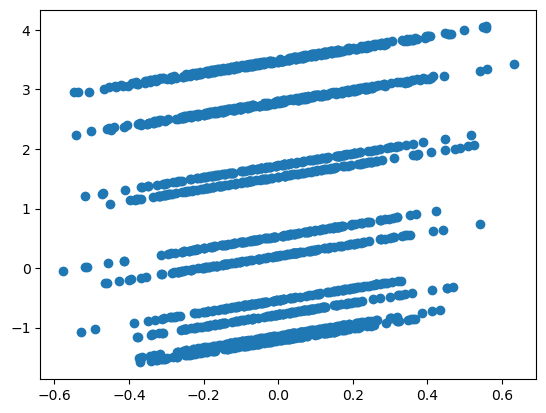

In [58]:
plt.scatter(amo_all.amo2_ersst, amo_all.amo)

In [59]:
# difference seems to be an offset per calendar month
amo2_os = (amo_all.amo - amo_all.amo2_ersst).loc[amo_all.index.month == 9].mean()

In [60]:
amo_2025 = amo_t.loc["2025-09-01"] - amo2_os

## Create time series for Climate Explorer

### September AMO (correlated with ENSO)

In [ ]:
amo_t_adj = amo_t.loc[amo_t.index.month == 9] - amo2_os
amo_t_adj.index = amo_t_adj.index.year

 # csv for climate explorer
csv_fnm = "hurricane-melissa_amo-sep_ersst"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create header lines for upload to Climate Explorer 
str1 = "# contact :: September AMO from ERSST SSTs (https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc) - Hurricane Melissa, c.barnes22@imperial.ac.uk"
str2 = "# amo [degC] AMO (SST averaged over 0°-60°N, 0°-80°W minus SST averaged over 60°S-60°N, shifted to have mean 0; Trenberth et al. 2016) at "+csv_fnm+".dat"
head = "# year amo"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
amo_t_adj.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

### Weighted decadal mean

Weights from https://www.ncl.ucar.edu/Applications/Scripts/index_amo_1.ncl:
```
wgts_decade = (/ 1,6,19,42,71,96,106,96,71,42,19,6,1 /)*1.0
wgts_decade    = wgts_decade/sum(wgts_decade)
```

In [90]:
amo_t_ann = amo_t.resample("YS-APR").mean()
amo_t_ann.index = amo_t_ann.index.year
amo_t_ann.to_csv("data/amo-trenberth-ann_ersst.csv")

Decadal smoothing calculated in R because it seems to be much easier to do a weighted filter there

In [ ]:
# manually smooth using weights from NASA
amo_da = amo_t.resample("YS").mean().to_xarray().amo

weights = [1,6,19,42,71,96,106,96,71,42,19,6,1]
weights = [w / sum(weights) for w in weights]

w_arr = xr.DataArray(weights, dims=['window'])
amo_sm = amo_da.rolling(time = 13, center=True, min_periods = 1).construct('window').dot(w_arr).rename("amo_sm")

# can't cope with missing values so have to fill in last few years manually

for i in range(166,len(amo_da)):
    vals = amo_da.isel(time = slice(i-6,i+7)).values
    vweights = weights[:len(vals)]
    vweights = [v / sum(vweights) for v in vweights]   # reweight
    wvals = [w*v for w,v in zip(vals, vweights)]
    amo_sm[i] = sum(wvals)

In [347]:
amo_sm

<xarray.DataArray 'amo_sm' (time: 172)> Size: 1kB
array([       nan,        nan,        nan,        nan,        nan,
              nan, 1.07778704, 1.06708757, 1.05679456, 1.052948  ,
       1.05869294, 1.07128591, 1.08389338, 1.0900737 , 1.0875581 ,
       1.07900119, 1.07020335, 1.06745702, 1.07547255, 1.09609884,
       1.12757869, 1.1646899 , 1.19932016, 1.2217718 , 1.2232111 ,
       1.19934986, 1.15429165, 1.1012838 , 1.0586291 , 1.04120598,
       1.05195316, 1.07950062, 1.1042195 , 1.10961319, 1.09124948,
       1.05700269, 1.0200386 , 0.9904763 , 0.97201377, 0.96442317,
       0.96702136, 0.9797612 , 1.0008861 , 1.02502343, 1.04454332,
       1.05231595, 1.04482266, 1.02297187, 0.99152333, 0.95857632,
       0.93357185, 0.92463395, 0.93437799, 0.9571912 , 0.98111644,
       0.993476  , 0.98888097, 0.97296453, 0.95890422, 0.95853709,
       0.97379398, 0.99578072, 1.0115177 , 1.01289525, 1.00092719,
       0.98297092, 0.96740044, 0.96070265, 0.96713954, 0.9890916 ,
       1.02550072, 1.07039243, 1.11510037, 1.15325066, 1.18512826,
       1.21603872, 1.249805  , 1.28379099, 1.31016003, 1.32253997,
       1.3213154 , 1.31259253, 1.30247028, 1.29257311, 1.28042466,
       1.2636241 , 1.24270756, 1.22046079, 1.19943683, 1.18018672,
       1.16234151, 1.146716  , 1.13650797, 1.13595479, 1.14712473,
       1.16807757, 1.19355613, 1.21708119, 1.23286077, 1.2367218 ,
       1.22691603, 1.20556623, 1.17906953, 1.15614349, 1.14292647,
       1.13899246, 1.13816436, 1.13300401, 1.11989686, 1.10039293,
       1.07854927, 1.0574002 , 1.03697305, 1.01502064, 0.98898577,
       0.95774708, 0.92330368, 0.89083374, 0.86707604, 0.85706283,
       0.86115924, 0.87555691, 0.89451384, 0.91308952, 0.92785126,
       0.93600809, 0.93539824, 0.92527012, 0.90817184, 0.89018208,
       0.87872731, 0.87891752, 0.88980432, 0.90374587, 0.90991888,
       0.90131941, 0.88030372, 0.8580036 , 0.84818757, 0.85940231,
       0.8913593 , 0.93679886, 0.98577349, 1.02940308, 1.06136519,
       1.07930225, 1.08654674, 1.09128394, 1.10271721, 1.12511441,
       1.1546207 , 1.18221423, 1.19983554, 1.20592226, 1.20464221,
       1.20034697, 1.19289326, 1.17776257, 1.15188034, 1.11813453,
       1.08509126, 1.06208641, 1.05412082, 1.0614569 , 1.08238779,
       1.11483302, 1.15428317, 1.19228256, 1.21904421, 1.2284745 ,
       1.21999002, 1.19671988])
Coordinates:
  * time     (time) datetime64[ns] 1kB 1854-01-01 1855-01-01 ... 2025-01-01

In [ ]:
# amo_t.rolling(12*5, center = True, min_periods = 6*5).mean().plot()
amo_t.rolling(121, center = True, min_periods = 61).mean().plot(ax = plt.gca())
# amo_t.rolling(121, center = True, min_periods = 61).mean().resample("YS-APR").mean().plot(ax = plt.gca(), color = "k")
amo_t.rolling(121, center = True, min_periods = 61).mean().resample("YS").mean().plot(ax = plt.gca(), color = "k")
# amo_t.rolling(121, center = True, min_periods = 61).mean().loc[amo_t.index.month == 10].plot(ax = plt.gca(), color = "gold")

# amo_t.resample("YS-APR").mean().rolling(11, center = True, min_periods = 6).mean().plot(ax = plt.gca(), color = "darkred")
amo_t.resample("YS").mean().rolling(11, center = True, min_periods = 6).mean().plot(ax = plt.gca(), color = "darkblue")

amo_sm.to_dataframe().plot(ax = plt.gca(), color = "red")

plt.legend("upper left")

<Axes: xlabel='time'>

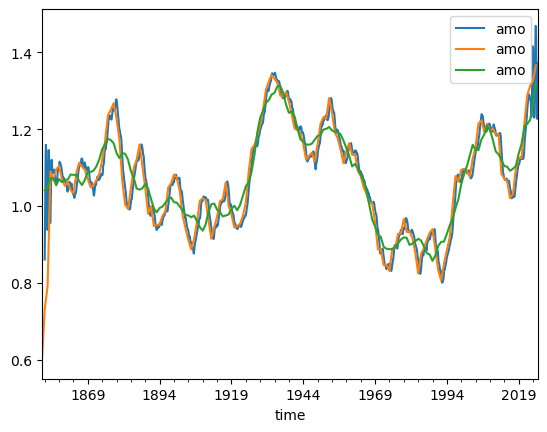

In [355]:
amo_t.rolling(12*5, center = True, min_periods = 6*5).mean().plot()
amo_t.resample("YS-MAR").mean().rolling(5, center = True, min_periods = 3).mean().plot(ax = plt.gca())
amo_sm10.plot(ax = plt.gca())

In [ ]:
# create time series for Climate Explorer
amo_t_adj = amo_t.loc[amo_t.index.month == 9] - amo2_os
amo_t_adj.index = amo_t_adj.index.year

 # csv for climate explorer
csv_fnm = "hurricane-melissa_amo-sep_ersst"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create header lines for upload to Climate Explorer 
str1 = "# contact :: September AMO from ERSST SSTs (https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc) - Hurricane Melissa, c.barnes22@imperial.ac.uk"
str2 = "# amo [degC] AMO (SST averaged over 0°-60°N, 0°-80°W minus SST averaged over 60°S-60°N, shifted to have mean 0; Trenberth et al. 2016) at "+csv_fnm+".dat"
head = "# year amo"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
amo_t_adj.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

### Unweighted decadal smoother

In [364]:
# create time series for Climate Explorer
amo_sm10 = amo_t.rolling(121, center = True, min_periods = 61).mean().resample("YS").mean()
amo_sm10.index = amo_sm10.index.year

 # csv for climate explorer
csv_fnm = "hurricane-melissa_amo-sm10_ersst"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create header lines for upload to Climate Explorer 
str1 = "# contact :: 10-year smoothed AMO from ERSST SSTs (https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc) - Hurricane Melissa, c.barnes22@imperial.ac.uk"
str2 = "# amo [degC] AMO (SST averaged over 0°-60°N, 0°-80°W minus SST averaged over 60°S-60°N, averaged over 121 months and then per calendar year); Trenberth et al. 2016) at "+csv_fnm+".dat"
head = "# year amo"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
amo_sm10.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

# Other SST products

https://www.metoffice.gov.uk/hadobs/hadsst3/data/HadSST.3.1.1.0/netcdf/HadSST.3.1.1.0.median_netcdf.zip

# Climate model time series

## Annual max PI

In [ ]:
bxn,bxx,byn,byx = [-80,-60,12,18]

fl = glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/hurricane-melissa/potential-intensity/cmip6/caribbean_pi_*.nc")

for fnm in fl:

    mdl = "_".join(fnm.split("_")[6:8])
    da = wrap_lon(xr.open_dataset(fnm).vmax)
    ts = da.sel(lon = slice(bxn,bxx), lat = slice(byn,byx)).mean(["lat", "lon"])
    ts_vmax = ts.resample(time = "YS").max()
    ts_vmax = ts_vmax.assign_coords(time = ts_vmax.time.dt.year).rename(time = "year").to_dataframe()
    
    # csv for climate explorer
    csv_fnm = "hurricane-melissa_pi_cmip6_"+mdl
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP6 "+mdl+" maximum monthly potential intensity in the Caribbean - Hurricane Melissa, c.barnes22@imperial.ac.uk"
    str2 = "# vmax [m/s] Annual maximum of monthly potential intensity averaged over 80-60W, 12-18N at "+csv_fnm+".dat"
    head = "# year vmax"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts_vmax.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

### Timing of annual max PI

In [7]:
bxn,bxx,byn,byx = [-80,-60,12,18]

fl = sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/hurricane-melissa/potential-intensity/cmip6/caribbean_pi_*.nc"))
for fnm in fl:

    mdl = "_".join(fnm.split("_")[6:8])
    new_fnm = "mdl-eval/pi-timing_"+mdl+".csv"
    if os.path.exists(new_fnm): continue
        
    da = wrap_lon(xr.open_dataset(fnm).vmax)
    ts = da.sel(lon = slice(bxn,bxx), lat = slice(byn,byx)).mean(["lat", "lon"])

    vmax_month = xr.concat([ts.sel(time = str(y)).idxmax() for y in range(ts.time.dt.year.min().values, ts.time.dt.year.max().values+1)], "time")
    df = pd.DataFrame(index = vmax_month.dt.year, data = {mdl : vmax_month.dt.month})
    df.to_csv(new_fnm)


## Smoothed AMO

In [8]:
for fnm in glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/cmip6-modes-of-variability_CVDP/amo/*.nc"):
    gcm = re.sub(".+trenberth_|_[0-9]{6}-[0-9]{6}.nc","",fnm)
    print(gcm)

    amo = xr.open_dataset(fnm).amo

    amo_sm10 = amo.rolling(time = 121, center = True, min_periods = 61).mean().resample(time = "YS").mean()
    amo_sm10 = amo_sm10.assign_coords(time = amo_sm10.time.dt.year).rename(time = "year").to_dataframe()

    # csv for climate explorer
    csv_fnm = "hurricane-melissa_amo-sm10_cmip6_"+gcm
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP6 "+gcm+" 10-year smoothed AMO - Hurricane Melissa, c.barnes22@imperial.ac.uk"
    str2 = "# amo [degC] AMO (SST averaged over 0°-60°N, 0°-80°W minus SST averaged over 60°S-60°N, averaged over 121 months and then per calendar year); Trenberth et al. 2016) at "+csv_fnm+".dat"
    head = "# year amo"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    amo_sm10.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)
print("Done.")

Done.
